# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.189678,False,5.600430
1,1.388721,False,2.093958
2,0.310346,True,8.289784
3,1.913677,False,4.320300
4,1.694236,False,3.616701
...,...,...,...
995,-0.417768,False,-0.910359
996,0.822609,False,0.387237
997,-1.059541,True,2.176587
998,2.330745,False,4.708835


<Axes: xlabel='v0'>

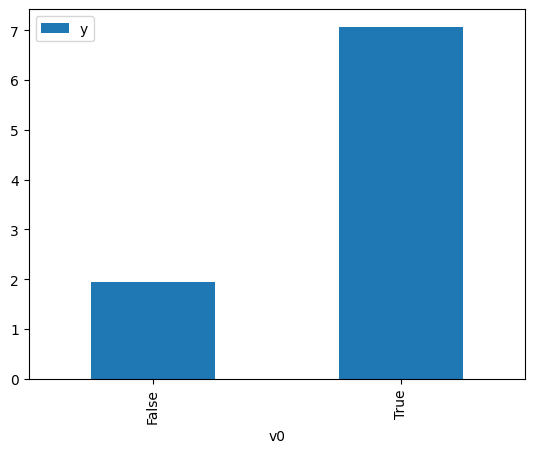

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

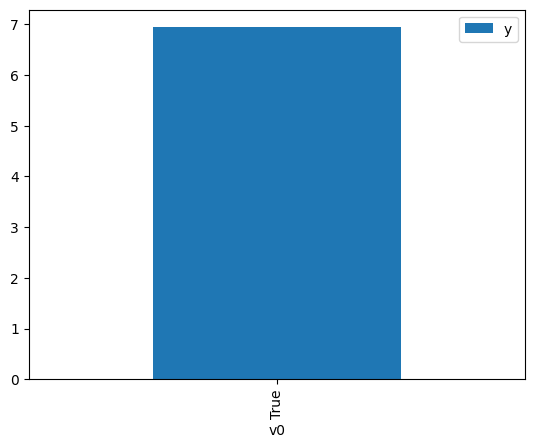

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.019356,False,-2.347354,0.500862,1.996559
1,0.721223,False,1.808889,0.483995,2.066135
2,2.625687,False,5.881100,0.465584,2.147840
3,1.135806,False,1.664204,0.479982,2.083411
4,0.240817,False,0.878289,0.488649,2.046460
...,...,...,...,...,...
995,1.062827,False,2.114951,0.480688,2.080350
996,1.936814,False,4.098610,0.472236,2.117587
997,0.820606,False,1.303303,0.483033,2.070251
998,-0.382583,False,-2.777227,0.494690,2.021470


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.179666,True,7.359646,0.510759,1.957871
1,-1.304697,True,2.206922,0.496372,2.014616
2,2.146927,True,11.696896,0.529794,1.887525
3,0.931729,True,7.280872,0.518043,1.930343
4,0.256639,True,5.648205,0.511505,1.955016
...,...,...,...,...,...
995,-1.304697,True,2.206922,0.496372,2.014616
996,-0.799042,True,4.638932,0.501274,1.994918
997,0.387640,True,7.164544,0.512774,1.950178
998,0.036980,True,5.724190,0.509376,1.963185


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.608e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):                        0.00
Time:                        23:43:16   Log-Likelihood:                         -1420.5
No. Observations:                1000   AIC:                                      2845.
Df Residuals:                     998   BIC:                                      2855.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3400      0.028     84.977      0.000       2.286       2.394
x2             4.9894      0.050    100.109      0.000       4.892       5.087
==============================================================================
Omnibus:                        0.410   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.454
Skew:                          -0.047   Prob(JB):                        0.797
Kurtosis:                       2.955   Cond. No.                         2.22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""